## Generating the Truth (the observation values for assimilation)

We run the forward model and observe it at specific times.

In [1]:
import Simulator
import Observation
import Statistics
import KalmanFilter

### Definition of grid and advection diffusion system

We solve the equation

$\frac{\partial X(t,s)}{\partial t} = \nabla \cdot D \nabla X(t,s) - v_t \cdot \nabla X(t,s) + \zeta X(t,s)  + \epsilon(t,s)$

where $\epsilon$ is $\mathcal{N}(0,\mathbf{R}_t)$ model error. 

As parameters we choose 
- $D=0.25$
- $\mathbf{v} = (1.0,0.0)^\top$
- $\zeta=-0.0001$.

For the numerical solution a temporal forward amd spatial central finite-difference scheme is employed such that 

$\mathbf{X}_{t+1} = \mathbf{M}\mathbf{X}_t + \mathbf
{\epsilon}_t$



In [2]:
grid = Simulator.Grid(nx=120,ny=80,dx=0.1,dy=0.1)
simulator = Simulator.Simulator(grid, D=0.25, v=[0.5,0.5])

### Definition of distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [3]:
import numpy as np
from random import random

def prior(grid, phi):
    """
    Constructing a Matern-type covariance prior with Matern-parameter phi
    where the matrix is normalized with the standard deviation
    """
    # INPUT! Bell mean
    bell_x = 0.25
    bell_y = 0.25
    sharpness = 2.0
    mean = np.zeros([grid.nx, grid.ny])
    for i in range(grid.nx):
        for j in range(grid.ny):
            mean[i,j] = np.exp(-sharpness*((i*grid.dx - bell_x*grid.nx*grid.dx)**2+(j*grid.dy - bell_y*grid.ny*grid.dy)**2))
    mean = np.reshape(mean,grid.N_x, order="F")
    # INPUT! Constant var
    var  = 0.1*np.ones(grid.N_x)

    # Matern covariance
    dist_mat = np.copy(grid.dist_mat)
    cov = (1+phi*dist_mat)*np.exp(-phi*dist_mat) 
    # Normalisation
    for i in range(grid.N_x):
        for j in range(grid.N_x):
            cov[i][j] = np.sqrt(var[i])*np.sqrt(var[j])*cov[i][j]
    
    return mean, cov

Please remember to set priors!


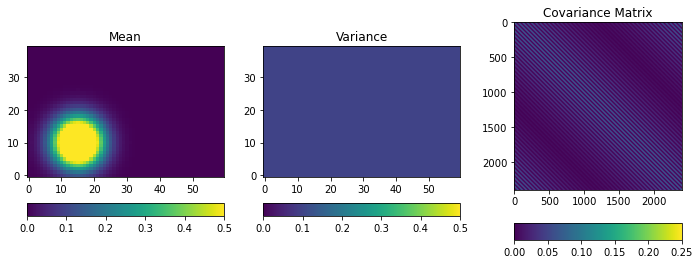

In [4]:
statistics = Statistics.Statistics(simulator)
mean, cov = prior(grid=grid, phi=2.0)
statistics.set(mean, cov)
statistics.plot()

### Setting observation moorings

In [5]:
import numpy as np

def observation_positions(grid, freq=10):
    poses = []
    for j in range(int(np.floor(grid.ny/freq))):
        for i in range(int(np.floor(grid.nx/freq))):
            poses.append([i*freq,j*freq])
    return poses


In [6]:
observation = Observation.Observation(simulator)


Remember to set observation positions and to set values!


In [7]:
poses = observation_positions(grid, freq=10)
observation.set_positions(poses)

### Temporal evolution of model

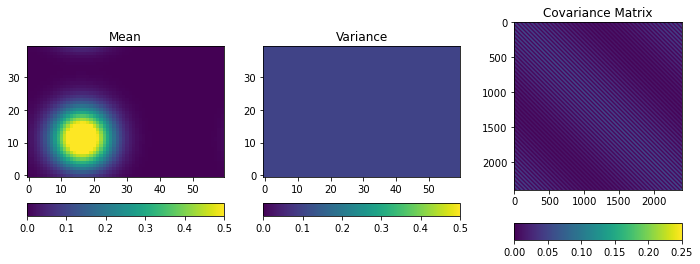

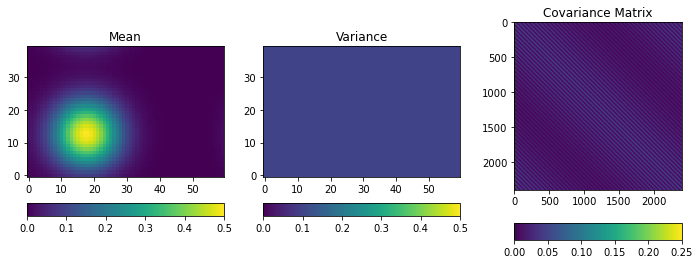

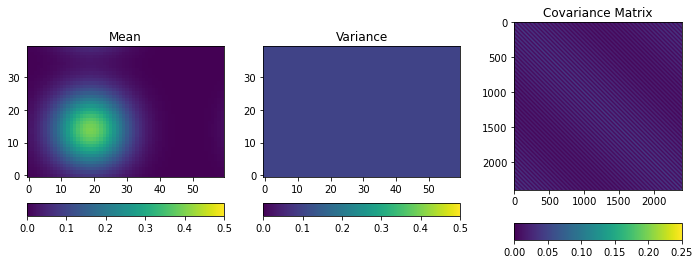

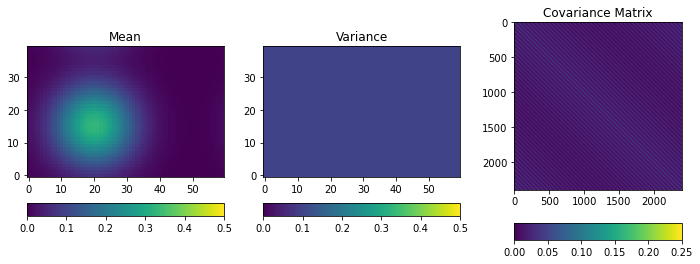

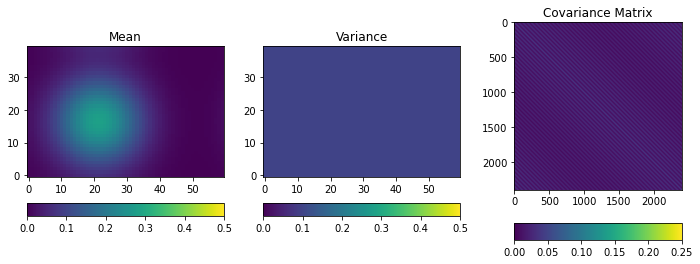

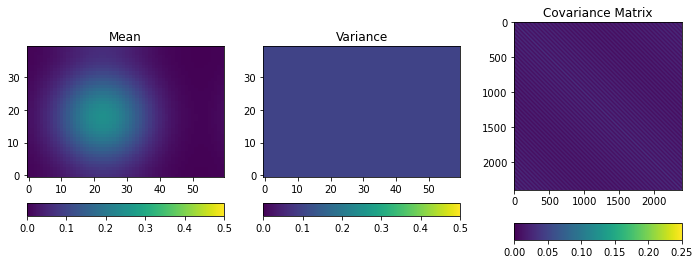

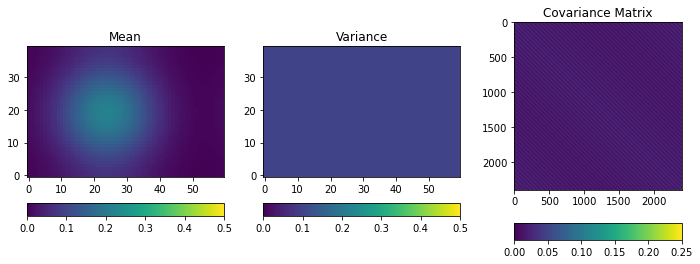

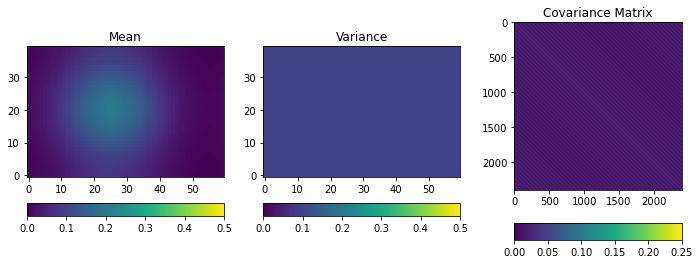

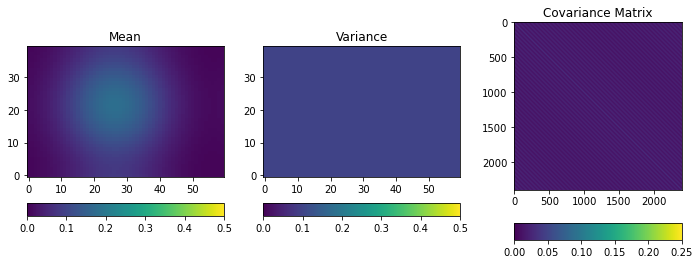

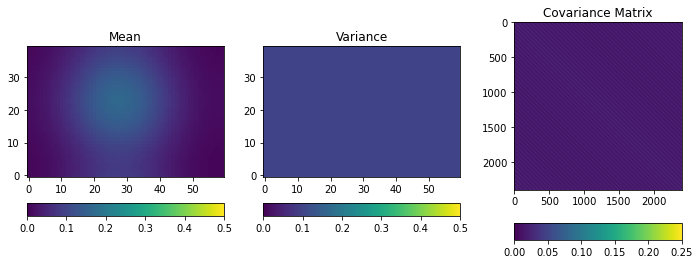

In [8]:
for t in range(10):
    statistics.propagate(25)
    observation.observe(statistics.mean)
    statistics.plot()

In [9]:
np.savetxt("observations.txt", observation.obses)